### Complejidad - Práctico 5 - Percolación
#### Lautaro Giordano

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import sys

sys.setrecursionlimit(500000)

In [15]:
def armar_red(size, p):
    # Armo una grilla size x size donde es 0 (negro) con probabilidad p
    # Es decir, los puntos "vacios" son negros y las paredes son blancas
    red = np.random.rand(size, size) < 1-p
    return red

# Funcion recursiva para detectar clusters de una red (y los guarda en la lista cluster):
def detectar_cluster(red_aux, x, y, cluster):
    if (x < 0 or x > len(red_aux) - 1 or y < 0 or y > len(red_aux[0]) - 1 or red_aux[x][y] == 1):
        return
    
    else:
        cluster.append([x,y])
        red_aux[x][y] = -1
        detectar_cluster(red_aux, x+1, y, cluster)
        detectar_cluster(red_aux, x-1, y, cluster)
        detectar_cluster(red_aux, x, y+1, cluster)
        detectar_cluster(red_aux, x, y-1, cluster)

# Funcion que recorre la red y guarda todos los distintos clusters en una lista
def lista_clusters(red):
    clusters = []
    # Me hago una copia de la red porque voy a borrar los clusters despues de detectarlos
    red_aux = red.copy()
    for x in range(len(red)):
        for y in range(len(red[0])):
            if red_aux[x][y] == 0:
                cluster = []
                detectar_cluster(red_aux, x, y, cluster)
                clusters.append(cluster)

    return clusters

# Devuelve el tamaño del mayor cluster en la red
def max_cluster(red):
    clusters = lista_clusters(red)
    maximo = 0
    for cluster in clusters:
        if len(cluster) > maximo:
            maximo = len(cluster)
    return maximo


# Grafica los clusters usando una paleta discreta de colores proporcional
# al tamaño de los clusters
def graficar_clusters(size, p):
    red = armar_red(size, p)
    clusters = lista_clusters(red)

    # Ploteo la red con los clusters coloreados
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')

    # Creo una imagen RGB en blanco (255) y negro (0)
    colored_image = np.zeros((size, size, 3))
    colored_image[..., :] = np.expand_dims(red, axis=-1) * 255

    # Mapa de colores que voy a usar
    colormap = cm.get_cmap('Paired')

    # Normalizo el mapa de colores con el cluster más chico y más grande
    max_size = max(len(cluster) for cluster in clusters)
    min_size = min(len(cluster) for cluster in clusters)
    normalize = lambda size: (size - min_size) / (max_size - min_size) if max_size > min_size else 0

    # Coloreo cada cluster
    for cluster in clusters:
        size_normalized = normalize(len(cluster))
        # Si el tamaño del cluster es muy chico, lo pinto de blanco
        if (size_normalized < .01):
            color = 1
        else:
            color = colormap(size_normalized)[:3]  # colormap me da un vector [R, G, B, alpha], extraigo los primeros 3 (RGB estan entre 0 y 1 acá)
        for x, y in cluster:
            colored_image[x, y] = np.array(color) * 255  # Convierto a la escala 255

    # Muestro el mapa de colores
    ax.imshow(colored_image.astype(np.uint8))
    ax.axis('off')
    ax.set_title(f"Clusters coloreados (p={p})")

    fig.colorbar(cm.ScalarMappable(norm=None, cmap=colormap), ax=ax, orientation='vertical', label='Cluster Size')

    print(f'Hay {len([cluster for cluster in clusters if len(cluster)>1])} clusters (tamaño > 1) en la red, el cluster mas grande tiene {max(len(cluster) for cluster in clusters)} elementos')

    plt.show()

1)

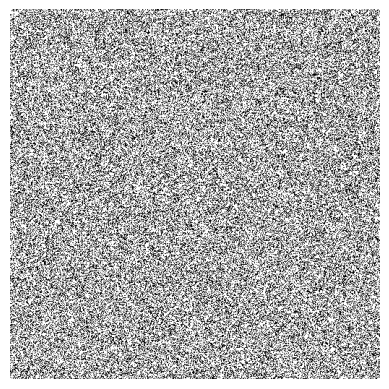

In [4]:
red = armar_red(512, 0.35)

plt.imshow(red, cmap='gray')
plt.axis('off');

2)

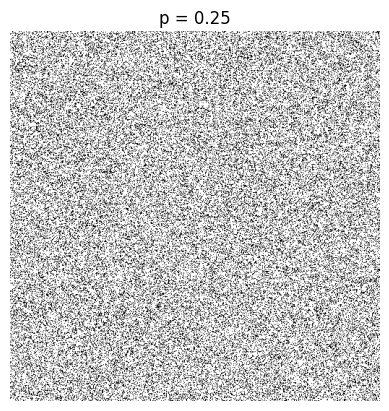

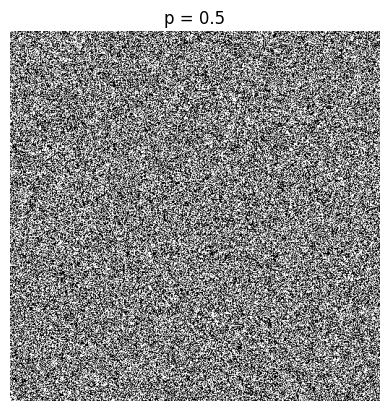

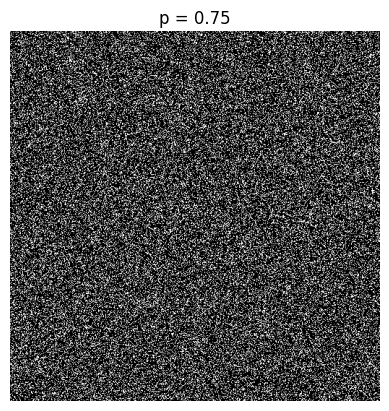

In [5]:
ps = [0.25, 0.5, 0.75]

for p in ps:
    red = armar_red(512, p)
    plt.figure()
    plt.imshow(red, cmap='gray')
    plt.axis('off')
    plt.title(f'p = {p}')

La primera red no parece percolada, mientras que en la última red parecería verse a simple vista la percolación, pero no está tan claro (mejor ver los clusters).

3.

/tmp/ipykernel_3775/1850882547.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Paired')


Hay 3285 clusters (tamaño > 1) en la red, el cluster mas grande tiene 25019 elementos


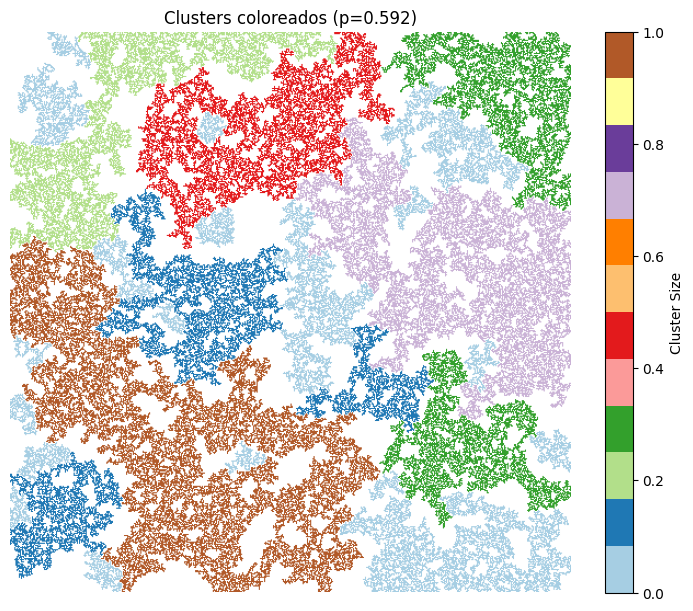

In [16]:
size = 512
p = 0.592

graficar_clusters(size, p);

Depende la semilla se ven entre de unas cuantos clusters grandes, los clusters muy chiquititos (menores al 1% del cluster más grande) directamente no los estoy graficando.

4.

In [17]:
probs = list(np.linspace(0.3, 0.55, 10)) + list(np.linspace(0.56, 0.65, 30)) + list(np.linspace(0.66, .85, 10))

mayor_cluster_mean = []
mayor_cluster_std = []
ocupacion = []
muchos_clusters = {p:[] for p in probs}


size = 512
reps = 10

for i, p in enumerate(probs):
    print(f"Iteracion {i+1}/{len(probs)}", end='\r')
    
    mayor_cluster_aux = []
    ocupacion_aux = []
    
    for rep in range(reps):
        red = armar_red(size, p)
        clusters = lista_clusters(red)
        clusters_sizes = [len(cluster) for cluster in clusters]

        muchos_clusters[p].append(clusters_sizes)
        
        mayor_cluster_aux.append(max(len(cluster) for cluster in clusters))
        # Cuento la cantidad de ocupacion (sitios negros)
        ocupacion_aux.append(size**2 - np.sum(red))

    mayor_cluster_mean.append(np.mean(mayor_cluster_aux)) 
    mayor_cluster_std.append(np.std(mayor_cluster_aux))
    ocupacion.append(np.mean(ocupacion_aux))

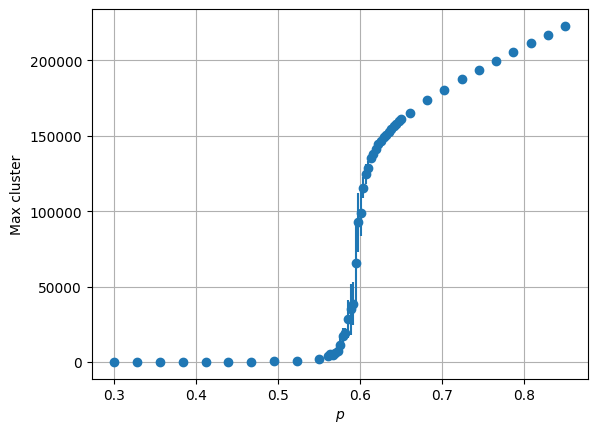

In [18]:
plt.errorbar(probs, mayor_cluster_mean, yerr=mayor_cluster_std, fmt='o')
plt.xlabel(r'$p$')
plt.ylabel('Max cluster')
plt.grid()

En el gráfico de arriba se ve la transición en el tamaño del mayor cluster en función de p justo para el valor esperado de $p \approx 0.59$

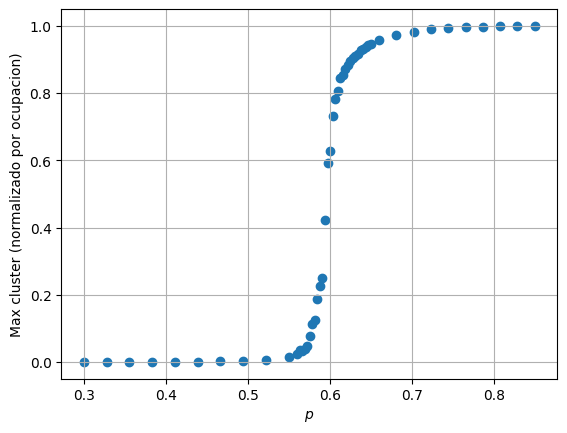

In [19]:
mayor_cluster_norm = [mayor_cluster_mean[i] / ocupacion[i] for i in range(len(mayor_cluster_mean))]

plt.scatter(probs, mayor_cluster_norm, marker='o')
plt.xlabel(r'$p$')
plt.ylabel('Max cluster (normalizado por ocupacion)')
plt.grid()

La transición también se ve normalizando por los sitios ocupados. El mayor cluster pasa rápidamente de valores cercanos al 0 (es decir, el cluster no representa una proporción importante del total de sitios ocupados) a 1 (donde prácticamente todos los sitios ocupados pertenecen al cluster).

5.

In [20]:
probs = [0.3, 0.59, 0.7]
reps = 10

clusters_dict = {p:[] for p in probs}
size = 512

for i, p in enumerate(probs):
    print(f"Iteracion {i+1}/{len(probs)}", end='\r')

    for rep in range(reps):
        red = armar_red(size, p)
        clusters = lista_clusters(red)

        cluster_lens = [len(cluster) for cluster in clusters]

        clusters_dict[p].append(cluster_lens)

    # Pongo todos los elementos en una lista (estaban en una lista de listas)
    clusters_dict[p] = [elem for sublist in clusters_dict[p] for elem in sublist]


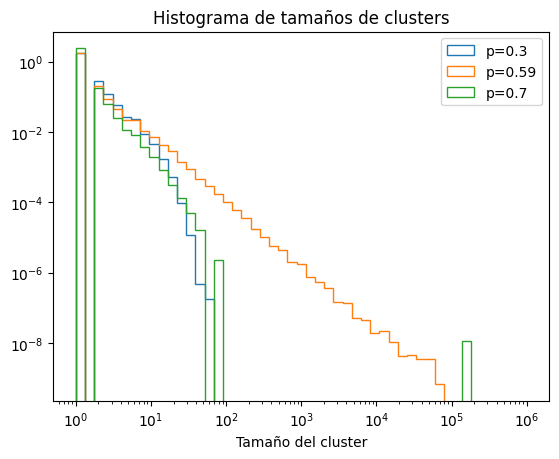

In [21]:
bins = np.logspace(0, 6, 50)

plt.hist(clusters_dict[0.3], bins=bins, density=True, histtype='step', label='p=0.3');
plt.hist(clusters_dict[0.59], bins=bins, density=True, histtype='step', label='p=0.59');
plt.hist(clusters_dict[0.7], bins=bins, density=True, histtype='step', label='p=0.7');
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Tamaño del cluster")
plt.title("Histograma de tamaños de clusters")
plt.legend()

Se ve que la distribución es libre de escala para $p\approx p_c$. Para calcular el exponente critico en este caso mejor voy a usar la distribución acumulada.

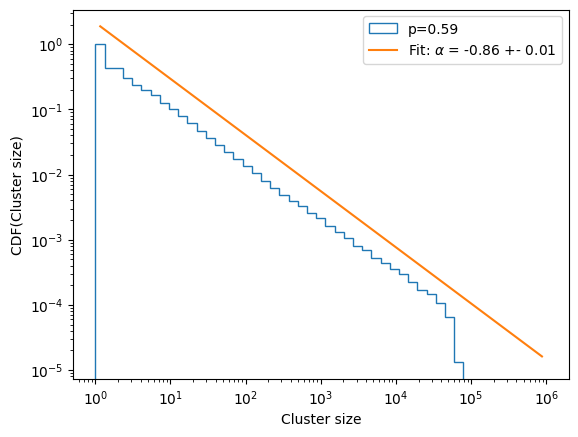

In [22]:
counts, bins, _ = plt.hist(clusters_dict[0.59], bins=bins, density=True, cumulative=-1, histtype='step', label='p=0.59');
# x: punto medio de los bins
x = (bins[1:] + bins[:-1]) / 2

# Ajusto una recta en el logaritmo de los datos
popt, pcov = np.polyfit(np.log(x[counts>0]), np.log(counts[counts>0]), 1, cov=True)
plt.plot(x, np.exp(popt[1]+1) * x**popt[0], label=r'Fit: $\alpha$ 'f'= {popt[0]:.2f} +- {np.sqrt(pcov[0,0]):.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cluster size')
plt.ylabel('CDF(Cluster size)')
plt.legend()


El exponente de la acumulada me da 0.86, así que el exponente de la distribución de clusters es 1.86, que es lo que esperábamos! Además, se ve un poco la característica pancita cerca del tamaño del sistema (que no aparecería en el caso de tamaño infinito).

6.

/tmp/ipykernel_3775/1850882547.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Paired')


Hay 3809 clusters (tamaño > 1) en la red, el cluster mas grande tiene 6383 elementos


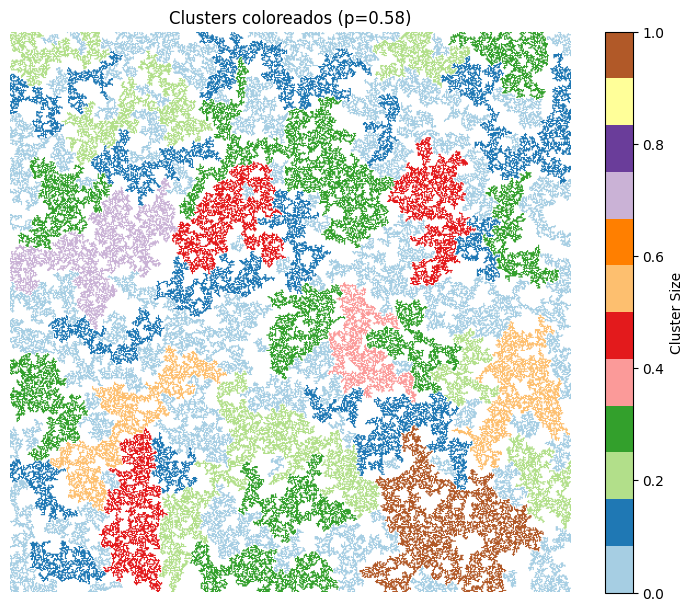

Hay 3231 clusters (tamaño > 1) en la red, el cluster mas grande tiene 67489 elementos


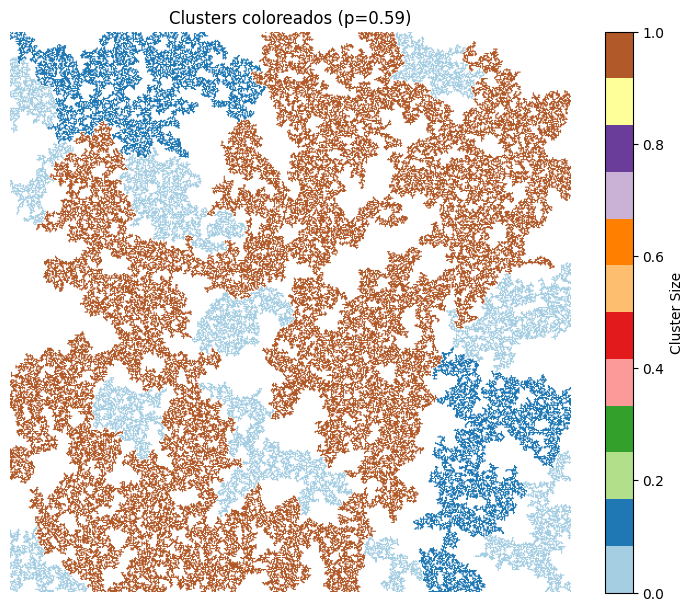

Hay 566 clusters (tamaño > 1) en la red, el cluster mas grande tiene 177063 elementos


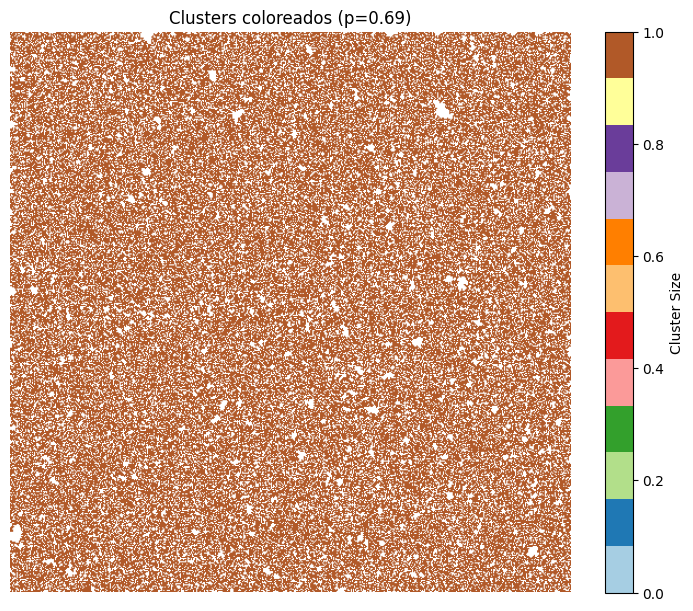

In [23]:
probs = [0.58, 0.59, 0.69]
size = 512

for p in probs:
    graficar_clusters(size, p)

7. De memoria: $p_{crit} = 1$ para 1D, ya que cualquier huequito ($p<1$) te divide el cluster más grande en dos.